# VAST And FINK Combined Lightcurve Plotting

This notebook is for Plotting the optical and radio variant sources side by side, as well as a starting point for seeing how to combine the data from both plots into one.

In [1]:
#here are the necessary imports
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from io import StringIO
from vasttools.pipeline import Pipeline
from vasttools.query import Query
import Projecttools as pro #brand new module for frequently used code!

%matplotlib inline

In [2]:
cms = pd.read_pickle('Fink_2020_sources_matched_to_VAST_all_sources.pickle')
pro.family_sort(cms)
cms.groupby('family').size().sort_values(ascending=False)

family
AGN                827
Unknown            516
Galaxy             167
Solar System        81
Radio               70
Supernova           51
Multiwavelength     39
Star                21
dtype: int64

## Lets start with the radio preamble:

In [3]:
#This will automatically find the base directory that needed to be specified
pipe=Pipeline()
#this way, we can also load specific runs from the VAST pipeline:
my_run=pipe.load_run('tiles_corrected')

/opt/conda/lib/python3.9/site-packages/vasttools/pipeline.py:2609: UserWarning: Measurements have been loaded with vaex.
  warnings.warn("Measurements have been loaded with vaex.")


In [4]:
#Im just putting the eta and v threshholds because the eta-v analysis takes an actual eternity to complete and I already
#have the values here:
eta_thresh=2.315552652171963
v_thresh=0.2878888414273631

In [5]:
cms_candidates = pro.eta_v_candidate_filter(cms,my_run,eta_thresh,v_thresh)
cms_candidates.groupby('family').size().sort_values(ascending=False)

There are 213 candidate sources:


family
AGN                93
Unknown            53
Solar System       30
Galaxy             15
Radio               9
Star                5
Multiwavelength     4
Supernova           4
dtype: int64

## Now, the optical preamble:

Here, we'll list out any special sources we want to take a closer look at:

In [6]:
#These IDs are selected from the curated list of interesting sources (lightcurves can be seen via powerpoint.)
Special_IDS_1=['ZTF18abqsfre',
           'ZTF19acxyuza',
           'ZTF19aalpgfb',
           'ZTF20aakbllj',
           'ZTF19ablozzh',
           'ZTF18acyerqq',
           'ZTF19aaapnwa',
           'ZTF19aauczln',
           'ZTF19aarqoey',
           'ZTF18acnnguv',
           'ZTF18aczeoif',
           'ZTF19abbnhro']

There is a limit the number of requested sources that the FINK portal can give in one run (without things breaking). So, its best to request no more than 30 sources from the filtered catalogue (likely wont even need that much if the family of interest only contains a handful.)

In [7]:
cms_candidates_selection = cms_candidates.query('objectId == @Special_IDS_1')

#This reformats the index's in the candidate selection, so specific row ranges can be pulled out.
cms_candidates_selection = cms_candidates_selection.reset_index()
len(cms_candidates_selection)

12

In instances where the family in question is too large to request at once, here we will take a subset of the objects and request them. We're limiting the size of the subset to 30 sources max:

In [8]:
#This selects rows in our selection in interger index steps from a starting and stopping point
#test.loc[start:stop:steps]

#This selects up to 30 rows at a time
candidate_sample = cms_candidates_selection.loc[0:11:1]
len(candidate_sample)

12

In [9]:
#retreiving object data for several objects at once using the objectId list (with upperlim):
Idlist = candidate_sample['objectId'].to_list()

#defining column array for cutouts
cutouts=[
'b:cutoutScience_stampData',
'b:cutoutTemplate_stampData',
'b:cutoutDifference_stampData'
]

#this is the request made to the fink portal to pull out the info for each source
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': ','.join(Idlist), 
    'output-format': 'json',
    'withcutouts': 'True',
    'cols': ','.join(cutouts),
    'withupperlim': 'True' #important for lightcurve plotting
  }
)

In [10]:
#reads in json file data as DataFrame. fsd stands for 'FINK source data'
fsd=pd.read_json(StringIO(r.content.decode()))

## Candidate Selection and Plotting

In [11]:
candidate_sample

,index,objectId,matched_id,class,cdsxmatch,ra,dec,family
0,75,ZTF19aalpgfb,3300988,Unknown,Unknown,203.785435,3.272751,Unknown
1,110,ZTF18acyerqq,3855289,QSO,QSO,192.964023,-2.392626,AGN
2,113,ZTF19aaapnwa,3304681,QSO,QSO,176.964837,-7.411458,AGN
3,297,ZTF20aakbllj,3985063,Unknown,Unknown,143.550637,-7.611857,Unknown
4,416,ZTF19aauczln,3456705,QSO,QSO,324.160772,0.698314,AGN
5,570,ZTF19acxyuza,3642158,Galaxy,Galaxy,166.757954,-4.138944,Galaxy
6,602,ZTF18abqsfre,3187458,Radio,Radio,19.576867,2.968363,Radio
7,618,ZTF19aarqoey,3640015,Blazar,Blazar,144.910518,-3.251097,AGN
8,661,ZTF18acnnguv,3238791,QSO,QSO,142.717733,0.583038,AGN
9,761,ZTF19ablozzh,3403963,Unknown,Fail,36.540343,1.491337,Unknown


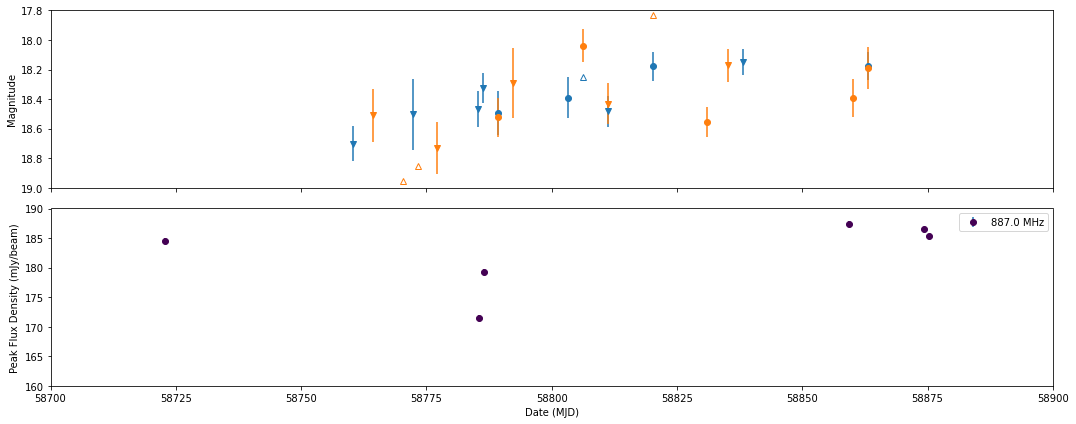

In [106]:
FINK_ID='ZTF19abbnhro'
pro.plot_lightcurves(my_run,fsd,cms_candidates_selection,FINK_ID,xlim=[58700,58900],vast_ylim=[160,190],fink_ylim=[19,17.8])

In [ ]:
pro.plot_cutouts(my_run,fsd,cms_candidates_selection,FINK_ID,vast_epoch='1')